A version of the code that is optimized to run for when there are T=2 types of agents/players, M=2 fronts, more agents than fronts, and every front must have at least one agent. This code reproduces results in Section 4 (more labelers than fronts). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from math import ceil, floor
import json

In [2]:
def WriteJson(name, data):
   j = json.dumps(data)
   with open(name,'a') as f:
      f.write(j)
      f.write('\n')
        
def prop_alloc(numA, numB, weights = [1, 1]):
    '''
    Allocate units proportionally. 
    
    Args: 
        numA, numB: nummber of type A, type B players, respectively.
        weights: list of weights on the two fronts
    '''
    weights = [val/sum(weights) for val in weights] # normalize 
    a0 = weights[0]*numA
    b0 = weights[0]*numB
    return [a0, b0]


def cost(numA, a0, numB, b0, weights = [1, 1], ref = 'A'):
    '''
    Cost to players type A, B for M=2 arrangement. 
    
    Args: 
        numA, numB: total number of type A, B players
        weights: list of weights on the two fronts
        ref: either 'A' or 'B', reference of the player type to calculate cost. 
    '''
    if (a0+ b0 ==0) | ((a0>= numA) & (b0>=numB)) |(a0<0) | (a0>numA) | (b0<0) | (b0>numB):
        return np.inf
    if ref == 'A':
        return weights[0]*b0/(a0+b0)+  weights[1]*(numB-b0)/(numA-a0 + numB-b0)
    elif ref == 'B':
        return weights[0]*a0/(a0+b0) + weights[1]*(numA-a0)/(numA-a0 + numB-b0)

def player_want_move(numA, a0, a0p, numB, b0, b0p, weights = [1, 1], ref = 'A', outcome_rule = 'mean'):
    '''
    Check whether player of type A or B has lower cost with [a0p, b0p] rather than [a0, b0]. 
    Mean outcome function is written to eliminate fractions to avoid rounding errors. 
    Median outcome function has cost 1 if labeled by opposite type, cost 0.5 if split, 0 if same type. 
    
    
    Args: 
        numA, numB: total number of type A, B players
        a0, b0: current number of type A, B players on front 0
        a0p, b0p: new number of type A, B players on front 0
        weights: list of weights on the two fronts
        ref: either 'A' or 'B', reference of the player to consider if cost is reduced
    Returns: 
        bool, True if player does want to move, False if it does NOT want to move
    
    '''
    a1 = numA - a0
    a1p = numA - a0p
    b1 = numB - b0
    b1p = numB - b0p
    w0 = weights[0]
    w1 = weights[1]
    # don't move if new location would give infinite cost by leaving a front empty
    # or using more than total number of type A, B players
    if (a0p+ b0p ==0) | ((a0p>= numA) & (b0p>=numB)) |(a0p<0) | (a0p>numA) | (b0p<0) | (b0p>numB):
        # if old location already had infinite cost
        if (a0+ b0 ==0) | ((a0>= numA) & (b0>=numB)) |(a0<0) | (a0>numA) | (b0<0) | (b0>numB):
            # if both old and new location have infinite cost, player moves by default
            return True 
        else:
            # if old location doesn't have infinite cost, player stays where it is
            return False
    if ref == 'A':
        if outcome_rule == 'mean':
            old_cost = w0*b0*(a1+b1)*(a0p+b0p)*(a1p+b1p) + w1*b1*(a0+b0)*(a0p+b0p)*(a1p+b1p)
            new_cost = w0*b0p*(a1p+b1p)*(a0+b0)*(a1+b1) + w1*b1p*(a0p+b0p)*(a0+b0)*(a1+b1)
        elif outcome_rule == 'median':
            old_cost = w0*(a0<b0) + 0.5*w0*(a0==b0) + w1*(a1<b1)+ 0.5*w1*(a1==b1)
            new_cost = w0*(a0p<b0p) + 0.5*w0*(a0p==b0p) + w1*(a1p<b1p)+ 0.5*w1*(a1p==b1p)
        if new_cost < old_cost:
            return True # player moves if strict reduction in cost
        else:
            return False # otherwise remains
    elif ref == 'B':
        if outcome_rule == 'mean':
            old_cost = w0*a0*(a1+b1)*(a0p+b0p)*(a1p+b1p) + w1*a1*(a0+b0)*(a0p+b0p)*(a1p+b1p)
            new_cost = w0*a0p*(a1p+b1p)*(a0+b0)*(a1+b1) + w1*a1p*(a0p+b0p)*(a0+b0)*(a1+b1)
        elif outcome_rule == 'median':
            old_cost = w0*(a0>b0) + 0.5*w0*(a0==b0) + w1*(a1>b1)+ 0.5*w1*(a1==b1)
            new_cost = w0*(a0p>b0p) + 0.5*w0*(a0p==b0p) + w1*(a1p>b1p)+ 0.5*w1*(a1p==b1p)
        if new_cost < old_cost:
            return True 
        else:
            return False
    

def find_stable(numArange = range(1, 20), numBrange = range(1, 20), ignore_range = [], outcome_rule = 'mean', 
               weights_list = [[0.5, 0.5]], store_json = None, explore_distance = False):
    '''
    Finds stable arrangement (if one exists) for nA, nB players. Produces plot showing (nA, nB) values where
    no stable arrangement exists. 
    
    Args: 
        numArange, numBrange: range of type A, type B players to consider
        ignore_range: list of pairs of (nA, nB) pairs to *not* consider (e.g. if already computer, or to speed up)
        outcome_rule: outcome function (median or mean)
        weights_list: list of lists of weights on fronts 0, 1 to consider. 
        store_json: if not None, a string for json name to store result in. 
        explore_distance: if True, calculate distance to proportional allocation
        
    
    '''
    for weights in weights_list:
        print(weights)

        store_results = []
        for numA in numArange:
            for numB in numBrange: 
                if (numA >= numB) & ([numA, numB] not in ignore_range):
                    # see which values are stable
                    store_stable = []
                    for a0 in range(numA+1):
                        for b0 in range(numB+1):
                            if  (not ((a0 ==0) & (b0 == 0))) & (not((a0==numA) & (b0==numB))):
                                stable_val = True #stable value defaults to True, overwritten if a deviation exists
                                # check each of the 4 possible moves from current arrangement. 
                                if player_want_move(numA, a0, a0+1, numB, b0, b0, weights, 'A', outcome_rule): 
                                    stable_val = [a0+1, b0]
                                if player_want_move(numA, a0, a0-1, numB, b0, b0, weights, 'A', outcome_rule): 
                                    stable_val = [a0-1, b0] 
                                if player_want_move(numA, a0, a0, numB, b0, b0+1, weights, 'B', outcome_rule): 
                                    stable_val = [a0, b0+1]
                                if player_want_move(numA, a0, a0, numB, b0, b0-1, weights, 'B', outcome_rule): 
                                    stable_val = [a0, b0-1] 
                                
                                store_stable.append([a0, b0, stable_val, cost(numA, a0, numB, b0, weights, 'A'), 
                                                      cost(numA, a0, numB, b0, weights, 'B')])
                    store_results.append([numA, numB, [[val[0], val[1]] for val in store_stable if 
                                                       val[2] == True]])

        results_dict = {'Mval': 2, 'weights': weights, 'outcome_rule': outcome_rule, 'store_results': store_results}
        if store_json is not None: 
            WriteJson(store_json + '.json', results_dict)

        not_stable = [[x, y] for [x, y, z] in store_results if (len(z) ==0)]
        
        plt.scatter([x for [x, y] in not_stable], [y for [x, y] in not_stable], c = 'r', s= 1, 
                    label = 'not stable')
        plt.xlim([1, max(pd.DataFrame(store_results)[0])])
        plt.ylim([1, max(pd.DataFrame(store_results)[0])])
        plt.xlabel('nA')
        plt.ylabel('nB')
        plt.legend()
        plt.title('M=2, weights ' + str([round(i, 2) for i in weights]) + ' ' + outcome_rule + ' outcome')
        plt.show()
        

        if explore_distance:
            # exploring the maximum number of moves you need to get in order to be stable
            # this gives the arrangment where one type changes the most from proportion, and yet is still stable. 
            max_move = [[val[0], val[1],
                     np.max(np.abs(np.array(val[2])- np.array(prop_alloc(val[0], val[1], weights))))] 
                        for val in store_results if (len(val[2]) >0)]
            print('Maximum distance from proportional is: ' + str(np.max(np.array(max_move)[:, 2])))
            

Reproduce plots in Figure 1 (N=2 fronts, varying weights, mean outcome function, showing when astable arrangement exists). Each plot takes about 10+ minutes. 

[0.5, 0.5]


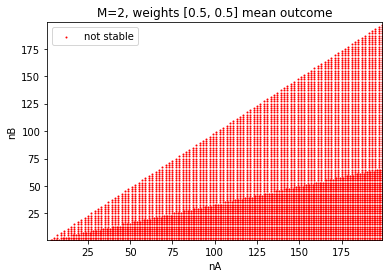

Maximum distance from proportional is: 0.5
[0.51, 0.49]


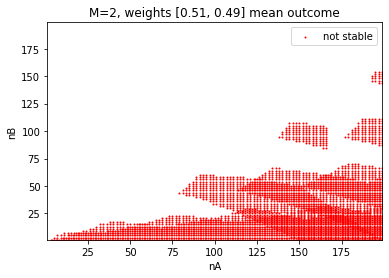

Maximum distance from proportional is: 0.980000000000004
[0.52, 0.48]


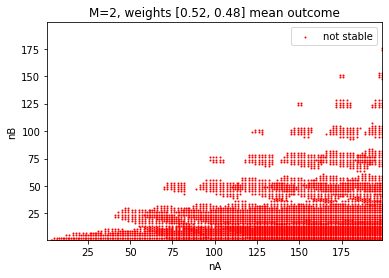

Maximum distance from proportional is: 0.9600000000000009
[0.55, 0.45]


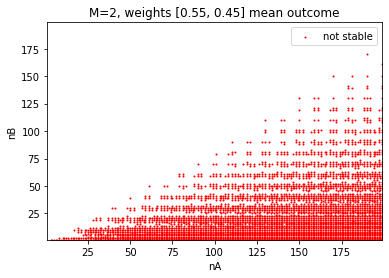

Maximum distance from proportional is: 0.9000000000000057
[0.6, 0.4]


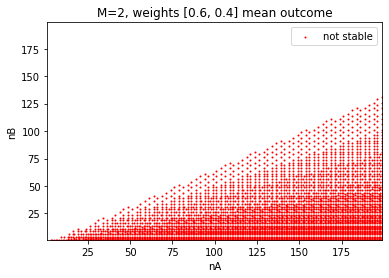

Maximum distance from proportional is: 0.8000000000000114
[0.9, 0.1]


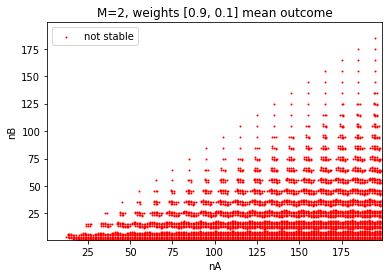

Maximum distance from proportional is: 0.9000000000000057


In [3]:
find_stable(numArange = range(1, 200), numBrange = range(1, 200), 
            weights_list = [[0.5, 0.5], [0.51, 0.49], [0.52, 0.48], [0.55, 0.45], [0.6, 0.4], [0.9, 0.1]], 
           explore_distance = True)